In [5]:
import kagglehub
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from google.colab import drive
import shutil

In [6]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [7]:
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

Using Colab cache for faster access to the 'diabetic-retinopathy-resized' dataset.


In [8]:
path

'/kaggle/input/diabetic-retinopathy-resized'

In [9]:
# ============================================
# STEP 4: Load the Labels CSV
# ============================================
dataset_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
labels_path = os.path.join(dataset_path, "trainLabels.csv")
labels_df = pd.read_csv(labels_path)

print("\n📊 Labels loaded!")
print(f"Total images: {len(labels_df)}")
print("\nFirst 5 rows:")
print(labels_df.head())


📊 Labels loaded!
Total images: 35126

First 5 rows:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


In [10]:
# Get information about the dataframe (data types, non-null values)
print("\nDataset Info:")
labels_df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   35126 non-null  object
 1   level   35126 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 549.0+ KB


In [11]:
# Get descriptive statistics for the numerical columns
print("\nDescriptive Statistics:")
display(labels_df.describe())


Descriptive Statistics:


,level
count,35126.000000
mean,0.526049
std,0.970390
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000


In [12]:
# Check the distribution of the original 'level' classes
print("\nDistribution of original 'level' classes:")
display(labels_df['level'].value_counts().sort_index())


Distribution of original 'level' classes:


,count
level,
0,25810
1,2443
2,5292
3,873
4,708


In [13]:
# ============================================
# STEP 6: Locate Image Folders
# ============================================
# Try cropped version first (cleaner images)
image_folder = os.path.join(dataset_path, "resized_train_cropped", "resized_train_cropped")

if not os.path.exists(image_folder):
    # Fallback to regular resized images
    image_folder = os.path.join(dataset_path, "resized_train", "resized_train")

# Verify images exist
sample_image_name = labels_df.iloc[0]['image']
sample_image_path = os.path.join(image_folder, f"{sample_image_name}.jpeg")

if os.path.exists(sample_image_path):
    print(f"\n✅ Images found at: {image_folder}")

    # Count total images
    total_images = len([f for f in os.listdir(image_folder) if f.endswith('.jpeg')])
    print(f"📸 Total image files: {total_images}")
else:
    print(f"\n❌ ERROR: Images not found!")
    print(f"Checked path: {image_folder}")
    print("\nAvailable folders:")
    !ls -R {dataset_path} | head -20




✅ Images found at: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
📸 Total image files: 35108


In [14]:
# ============================================
# STEP 5: Convert to Binary Classification
# ============================================
labels_df['binary_label'] = (labels_df['level'] > 0).astype(int)

print("\n🎯 Binary classification:")
print(labels_df['binary_label'].value_counts())
print(f"  No DR (0): {(labels_df['binary_label']==0).sum()} images ({(labels_df['binary_label']==0).sum()/len(labels_df)*100:.1f}%)")
print(f"  Has DR (1): {(labels_df['binary_label']==1).sum()} images ({(labels_df['binary_label']==1).sum()/len(labels_df)*100:.1f}%)")




🎯 Binary classification:
binary_label
0    25810
1     9316
Name: count, dtype: int64
  No DR (0): 25810 images (73.5%)
  Has DR (1): 9316 images (26.5%)



🖼️  Testing image loading...


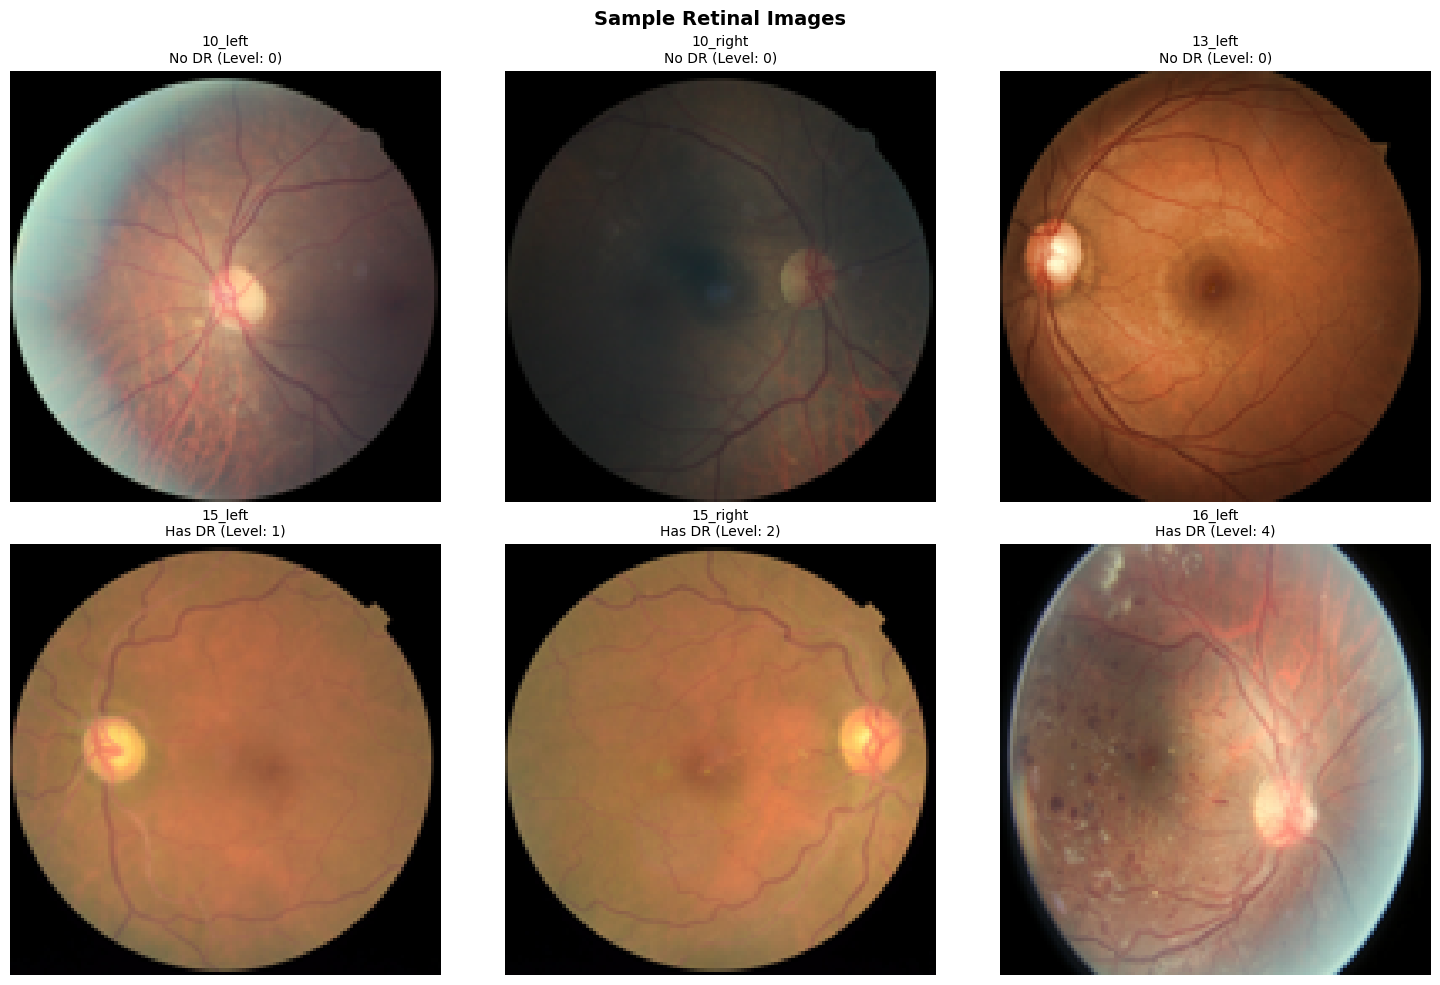

In [15]:
# ============================================
# STEP 7: Create Image Loading Function
# ============================================
def load_image(image_name, img_size=128):
    """
    Load and preprocess a single image

    Args:
        image_name: Image filename (e.g., '12345_left' or '12345_left.jpeg')
        img_size: Target size for resizing

    Returns:
        Numpy array of shape (img_size, img_size, 3) or None if failed
    """
    # Ensure proper extension
    if not image_name.endswith(('.jpeg', '.jpg', '.png')):
        image_name = f"{image_name}.jpeg"

    img_path = os.path.join(image_folder, image_name)

    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_size, img_size))
        return np.array(img)
    except FileNotFoundError:
        # Silent failure - we count these in extract_features_batch
        return None
    except Exception as e:
        return None

# ============================================
# STEP 8: Test Image Loading & Visualization
# ============================================
print("\n🖼️  Testing image loading...")

# Load sample images with different labels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Get diverse samples (some with DR, some without)
no_dr_samples = labels_df[labels_df['binary_label'] == 0].head(3)
has_dr_samples = labels_df[labels_df['binary_label'] == 1].head(3)
samples = pd.concat([no_dr_samples, has_dr_samples])

for i, (idx, row) in enumerate(samples.iterrows()):
    img_name = row['image']
    label = row['level']
    binary_label = row['binary_label']

    img = load_image(img_name)

    if img is not None:
        axes[i].imshow(img)
        dr_status = "No DR" if binary_label == 0 else "Has DR"
        axes[i].set_title(f"{img_name}\n{dr_status} (Level: {label})", fontsize=10)
        axes[i].axis('off')

plt.suptitle('Sample Retinal Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_images.png', dpi=100, bbox_inches='tight')
plt.show()



In [16]:
# ============================================
# STEP 9: Split Data (Train/Val/Test)
# ============================================
from sklearn.model_selection import train_test_split

# Use 10,000 images for faster experimentation
# (You can use all 35,126 images by removing .sample())
print("\n📊 Creating train/validation/test splits...")

labels_df_sample = labels_df.sample(n=30000, random_state=42)
print(f"Using {len(labels_df_sample)} images (sampled from {len(labels_df)} total)")

train_df, temp_df = train_test_split(
    labels_df_sample,
    test_size=0.3,
    random_state=42,
    stratify=labels_df_sample['binary_label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['binary_label']
)

print("\n📊 Data split complete:")
print(f"  Train:      {len(train_df):5d} images ({len(train_df)/len(labels_df_sample)*100:.1f}%)")
print(f"  Validation: {len(val_df):5d} images ({len(val_df)/len(labels_df_sample)*100:.1f}%)")
print(f"  Test:       {len(test_df):5d} images ({len(test_df)/len(labels_df_sample)*100:.1f}%)")

print("\n📈 Train set distribution:")
train_dist = train_df['binary_label'].value_counts().sort_index()
for label, count in train_dist.items():
    label_name = "No DR" if label == 0 else "Has DR"
    print(f"  {label_name} ({label}): {count:4d} images ({count/len(train_df)*100:.1f}%)")

# ============================================
# STEP 10: Save Splits for Later Use
# ============================================
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print("\n✅ Data splits saved to CSV files!")

# ============================================
# STEP 11: Summary
# ============================================
print("\n" + "="*50)
print("🎉 DATASET READY FOR EXPERIMENTS!")
print("="*50)
print(f"\n📁 Dataset location: {dataset_path}")
print(f"🖼️  Image folder: {image_folder}")
print(f"📊 Total images: {len(labels_df)}")
print(f"🎯 Using: {len(labels_df_sample)} images")
print("="*50)



📊 Creating train/validation/test splits...
Using 30000 images (sampled from 35126 total)

📊 Data split complete:
  Train:      21000 images (70.0%)
  Validation:  4500 images (15.0%)
  Test:        4500 images (15.0%)

📈 Train set distribution:
  No DR (0): 15458 images (73.6%)
  Has DR (1): 5542 images (26.4%)

✅ Data splits saved to CSV files!

🎉 DATASET READY FOR EXPERIMENTS!

📁 Dataset location: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7
🖼️  Image folder: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
📊 Total images: 35126
🎯 Using: 30000 images


EXPERIMENT 1: RANDOM FOREST WITH HOG FEATURES

📊 Dataset sizes:
   Train: 21000 images
   Val:   4500 images
   Test:  4500 images

STEP 1: FEATURE EXTRACTION

🔍 Visualizing HOG features...


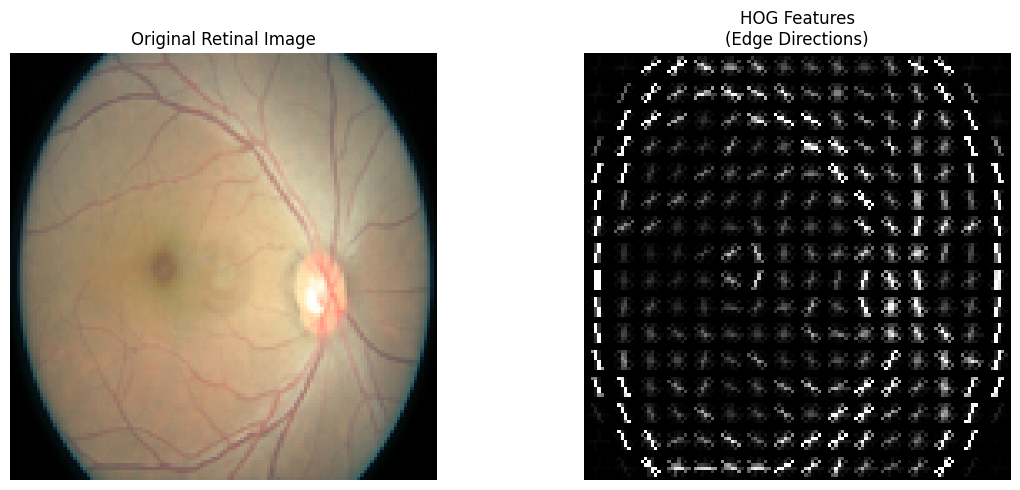

✅ HOG feature vector size: 8100 dimensions


In [ ]:
# ============================================
# EXPERIMENT 2: SVM (BASELINE ML)
# ============================================
# Objective: Establish traditional ML baseline using hand-crafted features

import numpy as np
import pandas as pd
from PIL import Image
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage import exposure
import cv2

# Load the splits we created earlier
train_df = pd.read_csv('train_split.csv')
val_df = pd.read_csv('val_split.csv')
test_df = pd.read_csv('test_split.csv')

print("="*60)
print("EXPERIMENT 1: RANDOM FOREST WITH HOG FEATURES")
print("="*60)
print(f"\n📊 Dataset sizes:")
print(f"   Train: {len(train_df)} images")
print(f"   Val:   {len(val_df)} images")
print(f"   Test:  {len(test_df)} images")

# ============================================
# STEP 1: FEATURE EXTRACTION
# ============================================
print("\n" + "="*60)
print("STEP 1: FEATURE EXTRACTION")
print("="*60)

def extract_hog_features(image, resize_to=128):
    """
    Extract Histogram of Oriented Gradients (HOG) features

    HOG captures edge directions and is excellent for detecting:
    - Blood vessel patterns
    - Lesions and hemorrhages
    - Exudates (fluid deposits)

    Args:
        image: PIL Image or numpy array
        resize_to: Size to resize image (smaller = faster)

    Returns:
        HOG feature vector
    """
    # Resize for speed (128x128 instead of 1024x1024)
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Resize to smaller size for faster processing
    image_small = cv2.resize(image, (resize_to, resize_to))

    # Convert to grayscale (HOG works on single channel)
    gray = cv2.cvtColor(image_small, cv2.COLOR_RGB2GRAY)

    # Extract HOG features
    # orientations: 9 bins for gradient directions
    # pixels_per_cell: 8x8 pixel cells
    # cells_per_block: 2x2 cells per block for normalization
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )

    return hog_features

# Visualize HOG features for understanding
print("\n🔍 Visualizing HOG features...")
sample_img_name = train_df.iloc[0]['image']
sample_img = load_image(sample_img_name, img_size=128)

# Get HOG with visualization
hog_features, hog_image = hog(
    cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY),
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    feature_vector=True
)

# Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(sample_img)
ax1.set_title('Original Retinal Image', fontsize=12)
ax1.axis('off')

ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('HOG Features\n(Edge Directions)', fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.savefig('hog_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ HOG feature vector size: {len(hog_features)} dimensions")

In [ ]:
# ============================================
# ENHANCED FEATURE EXTRACTION: HOG + COLOR
# ============================================
def extract_color_features(image):
    """
    Extract color statistics - Critical for DR detection!
    
    DR manifests as RED lesions (hemorrhages, microaneurysms)
    So color ratios are very informative.
    """
    r_mean = image[:,:,0].mean()
    g_mean = image[:,:,1].mean()
    b_mean = image[:,:,2].mean()
    
    # Color ratios (most important!)
    rg_ratio = r_mean / (g_mean + 1e-6)  # Red-to-Green (hemorrhages!)
    rb_ratio = r_mean / (b_mean + 1e-6)  # Red-to-Blue
    gb_ratio = g_mean / (b_mean + 1e-6)  # Green-to-Blue
    
    # Standard deviations (texture info)
    r_std = image[:,:,0].std()
    g_std = image[:,:,1].std()
    b_std = image[:,:,2].std()
    
    return np.array([r_mean, g_mean, b_mean, rg_ratio, rb_ratio, gb_ratio, r_std, g_std, b_std])

def extract_combined_features(image, resize_to=128):
    """Combine HOG (edges) + Color (lesions) features"""
    hog_feat = extract_hog_features(image, resize_to)
    color_feat = extract_color_features(image)
    return np.concatenate([hog_feat, color_feat])

print("✅ Enhanced feature extraction defined (HOG + Color)")
print("💡 Use extract_combined_features() instead of extract_hog_features()")

In [ ]:
# ============================================
# STEP 2: EXTRACT FEATURES FOR ALL IMAGES
# ============================================
print("\n" + "="*60)
print("STEP 2: EXTRACTING FEATURES FOR ALL IMAGES")
print("="*60)

def extract_features_batch(df, dataset_name):
    """Extract HOG features for a batch of images"""
    features = []
    labels = []
    failed = 0
    print(f"\n📸 Processing {dataset_name} set ({len(df)} images)...")

    start_time = time.time()

    for idx, row in df.iterrows():
        img_name = row['image']
        label = row['binary_label']

        # Load image
        img = load_image(img_name, img_size=128)

        if img is not None:
            # Extract COMBINED features (HOG + Color)
            combined_feat = extract_combined_features(img, resize_to=128)
            features.append(combined_feat)
            labels.append(label)
        else:
            failed += 1

        # Progress update every 500 images
        if (len(features)) % 500 == 0:
            print(f"   Processed: {len(features)}/{len(df)} images")

    elapsed = time.time() - start_time

    print(f"✅ Completed in {elapsed:.1f} seconds ({elapsed/len(features):.3f}s per image)")
    if failed > 0:
        print(f"⚠️  Failed to load {failed} images")

    return np.array(features), np.array(labels)

# Extract features for all datasets
X_train, y_train = extract_features_batch(train_df, "Training")
X_val, y_val = extract_features_batch(val_df, "Validation")
X_test, y_test = extract_features_batch(test_df, "Test")

print(f"\n📊 Feature shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")


STEP 2: EXTRACTING FEATURES FOR ALL IMAGES

📸 Processing Training set (21000 images)...
   Processed: 500/21000 images
   Processed: 1000/21000 images
   Processed: 1500/21000 images
   Processed: 2000/21000 images
   Processed: 2500/21000 images
   Processed: 3000/21000 images
   Processed: 3500/21000 images
   Processed: 4000/21000 images
   Processed: 4500/21000 images
   Processed: 5000/21000 images
   Processed: 5500/21000 images
   Processed: 6000/21000 images
   Processed: 6500/21000 images
   Processed: 7000/21000 images
   Processed: 7500/21000 images
   Processed: 8000/21000 images
   Processed: 8500/21000 images
   Processed: 9000/21000 images
   Processed: 9500/21000 images
   Processed: 10000/21000 images
   Processed: 10500/21000 images
   Processed: 11000/21000 images
   Processed: 11500/21000 images
   Processed: 12000/21000 images
   Processed: 12500/21000 images
   Processed: 13000/21000 images
   Processed: 13500/21000 images
   Processed: 14000/21000 images
   Proc

In [ ]:
# ============================================
# STEP 1: FEATURE SCALING (ADD THIS FIRST!)
# ============================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

print("\n" + "="*60)
print("STEP 1: FEATURE SCALING + DIMENSIONALITY REDUCTION")
print("="*60)

# Step 1a: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled")
print(f"   Original dimensions: {X_train.shape[1]}")

# Step 1b: Apply PCA (reduce to 100 components)
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_var = pca.explained_variance_ratio_.sum()
print(f"\n✅ PCA applied")
print(f"   Reduced to: {X_train_pca.shape[1]} components")
print(f"   Variance explained: {explained_var*100:.1f}%")

# Use PCA features for training
X_train_scaled = X_train_pca
X_val_scaled = X_val_pca
X_test_scaled = X_test_pca

# ============================================
# STEP 2: TRAIN SVM (WITH SCALED FEATURES!)
# ============================================
print("\n" + "="*60)
print("STEP 2: TRAINING SVM")
print("="*60)

svm_model = SVC(
    kernel='linear',  # Changed from 'rbf' to 'linear'
    C=0.1,            # Reduced from 1.0 for less overfitting
    class_weight='balanced',
    probability=True,
    random_state=42,
    verbose=True,
    max_iter=2000     # Increased iterations
)

print(f"\n⏳ Training SVM...")
start_time = time.time()

# Train on SCALED features!
svm_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"\n✅ Completed in {training_time:.2f}s")


STEP 1: FEATURE SCALING
✅ Features scaled
   Mean: -0.000000
   Std: 1.000000

STEP 2: TRAINING SVM

⏳ Training SVM...
[LibSVM]
✅ Completed in 1514.88s


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [21]:
# ============================================
# STEP 3: EVALUATION
# ============================================
print("\n" + "="*60)
print("STEP 3: MODEL EVALUATION")
print("="*60)

# Make predictions
print("\n🔮 Making predictions...")
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)

# Get probability scores
y_val_proba = svm_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Find optimal threshold using validation set
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
idx = np.argmin(np.abs(recall - 0.6))  # Target 60% recall
optimal_threshold = thresholds[idx]

print(f"\n🎯 Optimal threshold: {optimal_threshold:.3f} (default: 0.5)")

# Apply threshold to test set
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n📊 {dataset_name} Set Results:")
    print(f"   Accuracy:  {acc*100:.2f}%")
    print(f"   Precision: {prec*100:.2f}%")
    print(f"   Recall:    {rec*100:.2f}%")
    print(f"   F1 Score:  {f1*100:.2f}%")

    return acc, prec, rec, f1

train_acc, train_prec, train_rec, train_f1 = calculate_metrics(y_train, y_train_pred, "Training")
val_acc, val_prec, val_rec, val_f1 = calculate_metrics(y_val, y_val_pred, "Validation")
test_acc, test_prec, test_rec, test_f1 = calculate_metrics(y_test, y_test_pred, "Test")

# ROC AUC
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"\n🎯 Test Set ROC AUC: {test_auc:.4f}")



STEP 3: MODEL EVALUATION

🔮 Making predictions...


NameError: name 'precision_recall_curve' is not defined

In [ ]:
# ============================================
# STEP 4: VISUALIZATIONS
# ============================================
print("\n" + "="*60)
print("STEP 4: CREATING VISUALIZATIONS")
print("="*60)

# 1. Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No DR', 'Has DR'], yticklabels=['No DR', 'Has DR'])
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# 2. Classification Report Heatmap
report = classification_report(y_test, y_test_pred, output_dict=True,
                               target_names=['No DR', 'Has DR'], zero_division=0)
report_df = pd.DataFrame(report).iloc[:-1, :2].T
sns.heatmap(report_df, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], vmin=0, vmax=1)
axes[1].set_title('Classification Metrics Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('exp2_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVM (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - SVM', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('exp2_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.axvline(x=0.6, color='red', linestyle='--', label='Target Recall (60%)')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - SVM', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('exp2_precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ All visualizations saved!")

In [ ]:
# ============================================
# STEP 5: SAVE RESULTS
# ============================================
print("\n" + "="*60)
print("STEP 5: SAVING RESULTS")
print("="*60)

exp2_results = {
    'experiment': 'Experiment 2: SVM',
    'approach': 'Traditional ML',
    'features': 'HOG (Histogram of Oriented Gradients)',
    'feature_size': X_train.shape[1],
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'training_time_sec': training_time,
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'test_accuracy': test_acc,
    'test_precision': test_prec,
    'test_recall': test_rec,
    'test_f1': test_f1,
    'test_auc': test_auc,
    'optimal_threshold': optimal_threshold,
    'hyperparameters': {
        'kernel': 'rbf',
        'C': 1.0,
        'gamma': 'scale'
    }
}

# Append to existing results
try:
    results_df = pd.read_csv('experiment_results.csv')
    results_df = pd.concat([results_df, pd.DataFrame([exp2_results])], ignore_index=True)
except FileNotFoundError:
    results_df = pd.DataFrame([exp2_results])

results_df.to_csv('experiment_results.csv', index=False)

print("✅ Results saved to 'experiment_results.csv'")

# ============================================
# STEP 6: COMPARISON WITH EXPERIMENT 1
# ============================================
print("\n" + "="*60)
print("COMPARISON: RANDOM FOREST vs SVM")
print("="*60)

# Load experiment 1 results
exp1_results = results_df[results_df['experiment'].str.contains('Random Forest')].iloc[-1]

print("\n📊 Test Set Comparison:")
print(f"\n{'Metric':<15} {'Random Forest':<15} {'SVM':<15} {'Difference':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {exp1_results['test_accuracy']*100:>6.2f}%        {test_acc*100:>6.2f}%        {(test_acc-exp1_results['test_accuracy'])*100:>+6.2f}%")
print(f"{'Precision':<15} {exp1_results['test_precision']*100:>6.2f}%        {test_prec*100:>6.2f}%        {(test_prec-exp1_results['test_precision'])*100:>+6.2f}%")
print(f"{'Recall':<15} {exp1_results['test_recall']*100:>6.2f}%        {test_rec*100:>6.2f}%        {(test_rec-exp1_results['test_recall'])*100:>+6.2f}%")
print(f"{'F1 Score':<15} {exp1_results['test_f1']*100:>6.2f}%        {test_f1*100:>6.2f}%        {(test_f1-exp1_results['test_f1'])*100:>+6.2f}%")
print(f"{'AUC':<15} {exp1_results['test_auc']:>6.4f}         {test_auc:>6.4f}         {test_auc-exp1_results['test_auc']:>+6.4f}")
